<a href="https://colab.research.google.com/github/puni-ram48/DL-Reg-implementation-/blob/main/L2%2BDLreg_on_resnet_and_densenet_on_oxford_iiit_pet_Dataset_with_Results.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install datasets


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Generating train split:   0%|          | 0/3680 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3669 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3680
    })
    test: Dataset({
        features: ['image', 'label', 'image_id', 'label_cat_dog'],
        num_rows: 3669
    })
})


Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:03<00:00, 65.7MB/s]
Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 88.0MB/s]


Epoch 1/30, Train Acc: 0.05298913043478261, Val Acc: 0.10597826086956522, Test Acc: 0.10493322431180159
Epoch 2/30, Train Acc: 0.2673233695652174, Val Acc: 0.40217391304347827, Test Acc: 0.4303624965930771
Epoch 3/30, Train Acc: 0.6270380434782609, Val Acc: 0.6942934782608695, Test Acc: 0.7307168165712729
Epoch 4/30, Train Acc: 0.8104619565217391, Val Acc: 0.8342391304347826, Test Acc: 0.8301989642954484
Epoch 5/30, Train Acc: 0.8760190217391304, Val Acc: 0.8695652173913043, Test Acc: 0.8678113927500681
Epoch 6/30, Train Acc: 0.9076086956521738, Val Acc: 0.8980978260869565, Test Acc: 0.8822567457072772
Epoch 7/30, Train Acc: 0.9252717391304348, Val Acc: 0.90625, Test Acc: 0.8958844371763424
Epoch 8/30, Train Acc: 0.9422554347826086, Val Acc: 0.9130434782608695, Test Acc: 0.9040610520577814
Epoch 9/30, Train Acc: 0.9490489130434783, Val Acc: 0.9144021739130435, Test Acc: 0.910874897792314
Epoch 10/30, Train Acc: 0.9534646739130435, Val Acc: 0.9198369565217391, Test Acc: 0.91387298991550

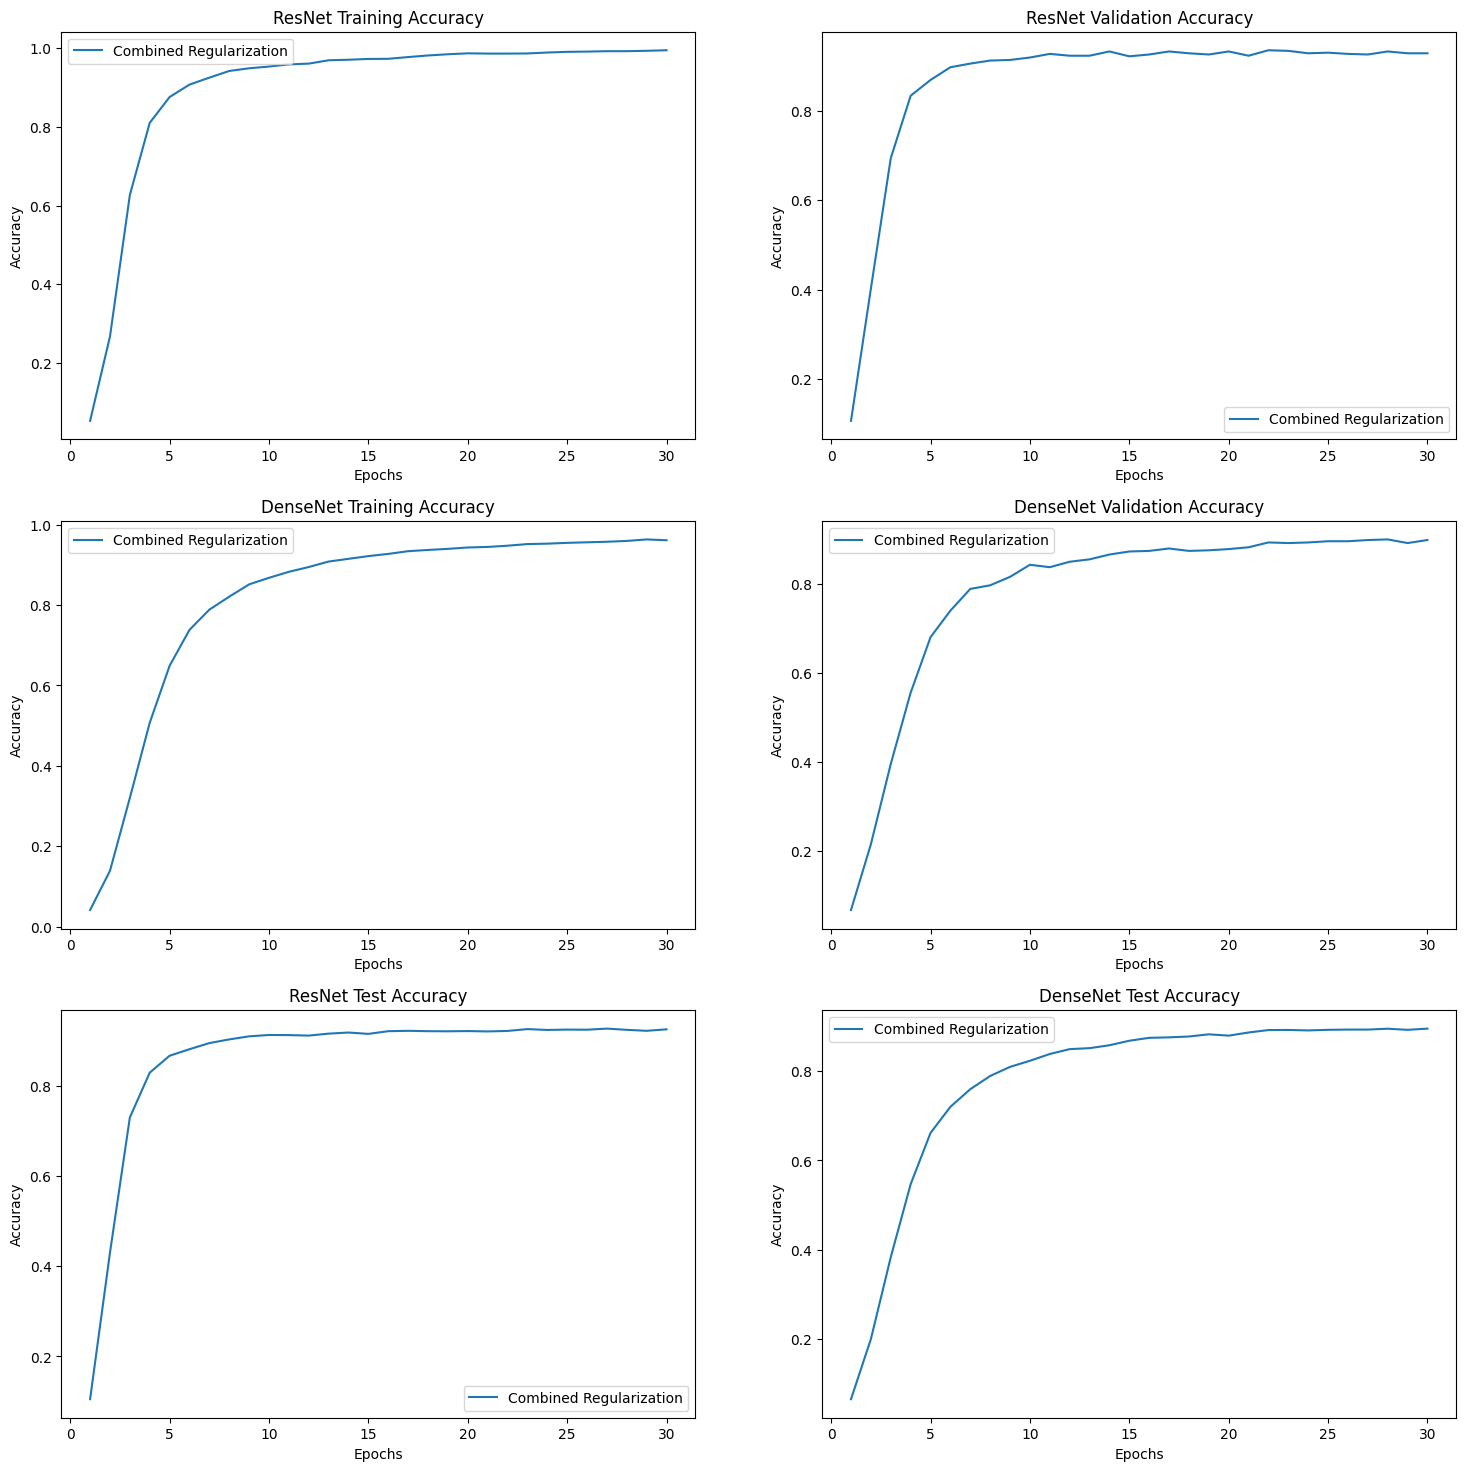

In [2]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import models
import matplotlib.pyplot as plt
import numpy as np
from datasets import load_dataset

# Define constants
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.2

# Load the Oxford-IIIT Pet dataset from Hugging Face
dataset = load_dataset('timm/oxford-iiit-pet')

# Print the dataset structure to check available splits
print(dataset)

# Identify the correct splits
train_split = 'train'
test_split = 'test'

# Custom dataset class to handle Hugging Face dataset
class OxfordIIITPetDataset(Dataset):
    def __init__(self, hf_dataset, transform=None):
        self.dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        sample = self.dataset[idx]
        image = sample['image']
        label = sample['label']
        if self.transform:
            image = self.transform(image)
        return image, label

# Transformations for the Oxford-IIIT Pet dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Lambda(lambda x: x.convert("RGB") if x.mode != "RGB" else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Prepare the dataset and dataloaders
train_val_dataset = OxfordIIITPetDataset(dataset[train_split], transform=transform)
test_dataset = OxfordIIITPetDataset(dataset[test_split], transform=transform)

# Split the train dataset into train and validation sets
train_size = int((1 - VALIDATION_SPLIT) * len(train_val_dataset))
val_size = len(train_val_dataset) - train_size
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Define the models with updated weights parameter
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)

# Modify the final layers to fit Oxford-IIIT Pet classes (37 classes)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)

num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)

# Define DL-Regularization
class DLRegularization(nn.Module):
    def __init__(self, model, lambda_reg=0.001):
        super(DLRegularization, self).__init__()
        self.model = model
        self.lambda_reg = lambda_reg

    def forward(self, x):
        output = self.model(x)
        return output

    def dl_reg_loss(self, x, output):
        batch_size = x.size(0)
        Z = nn.Linear(x.view(batch_size, -1).size(1), output.size(1), bias=False).to(x.device)
        reg_loss = torch.norm(Z(x.view(batch_size, -1)) - output) ** 2
        return self.lambda_reg * reg_loss

# Training function with combined L2 and DL-Regularization
def train_model(model, criterion, optimizer, num_epochs=NUM_EPOCHS, dl_regularizer=None):
    model.train()
    train_acc = []
    val_acc = []
    test_acc = []

    for epoch in range(num_epochs):
        running_corrects = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            if dl_regularizer:
                reg_loss = dl_regularizer.dl_reg_loss(inputs, outputs)
                loss += reg_loss

            loss.backward()
            optimizer.step()

            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / len(train_dataset)
        train_acc.append(epoch_acc.item())

        # Validation
        model.eval()
        val_corrects = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                val_corrects += torch.sum(preds == labels.data)

        epoch_val_acc = val_corrects.double() / len(val_dataset)
        val_acc.append(epoch_val_acc.item())

        # Test
        test_corrects = 0
        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                test_corrects += torch.sum(preds == labels.data)

        epoch_test_acc = test_corrects.double() / len(test_dataset)
        test_acc.append(epoch_test_acc.item())

        print(f'Epoch {epoch+1}/{num_epochs}, Train Acc: {epoch_acc.item()}, Val Acc: {epoch_val_acc.item()}, Test Acc: {epoch_test_acc.item()}')

    return train_acc, val_acc, test_acc

# Initialize device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Experiment with L2 and DL-Regularization on ResNet
resnet152 = models.resnet152(weights=models.ResNet152_Weights.IMAGENET1K_V1)
num_ftrs_resnet = resnet152.fc.in_features
resnet152.fc = nn.Linear(num_ftrs_resnet, 37)
resnet152 = resnet152.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet152.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
dl_regularizer = DLRegularization(resnet152, lambda_reg=0.001)
train_acc_combined_resnet, val_acc_combined_resnet, test_acc_combined_resnet = train_model(resnet152, criterion, optimizer, dl_regularizer=dl_regularizer)

# Experiment with L2 and DL-Regularization on DenseNet
densenet = models.densenet121(weights=models.DenseNet121_Weights.IMAGENET1K_V1)
num_ftrs_densenet = densenet.classifier.in_features
densenet.classifier = nn.Linear(num_ftrs_densenet, 37)
densenet = densenet.to(device)
optimizer = optim.SGD(densenet.parameters(), lr=LEARNING_RATE, weight_decay=0.001)
dl_regularizer = DLRegularization(densenet, lambda_reg=0.001)
train_acc_combined_densenet, val_acc_combined_densenet, test_acc_combined_densenet = train_model(densenet, criterion, optimizer, dl_regularizer=dl_regularizer)

# Plotting the results
epochs = range(1, NUM_EPOCHS + 1)
plt.figure(figsize=(18, 18))

plt.subplot(3, 2, 1)
plt.plot(epochs, train_acc_combined_resnet, label='Combined Regularization')
plt.title('ResNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 2)
plt.plot(epochs, val_acc_combined_resnet, label='Combined Regularization')
plt.title('ResNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 3)
plt.plot(epochs, train_acc_combined_densenet, label='Combined Regularization')
plt.title('DenseNet Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 4)
plt.plot(epochs, val_acc_combined_densenet, label='Combined Regularization')
plt.title('DenseNet Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 5)
plt.plot(epochs, test_acc_combined_resnet, label='Combined Regularization')
plt.title('ResNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(3, 2, 6)
plt.plot(epochs, test_acc_combined_densenet, label='Combined Regularization')
plt.title('DenseNet Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


In [3]:
def calculate_accuracy(accuracy_list):
    final_accuracy = accuracy_list[-1] * 100
    return final_accuracy

# Calculate test accuracies
train_acc_combined_resnet_pct = calculate_accuracy(train_acc_combined_resnet)
val_acc_combined_resnet_pct= calculate_accuracy( val_acc_combined_resnet)
test_acc_combined_resnet_pct= calculate_accuracy( test_acc_combined_resnet )
train_acc_combined_densenet_pct=calculate_accuracy(train_acc_combined_densenet)
val_acc_combined_densenet_pct= calculate_accuracy(val_acc_combined_densenet)
test_acc_combined_densenet_pct=calculate_accuracy(test_acc_combined_densenet)

# Print test accuracies
print(f'Train  Accuracy of ResNet with L2 Regularization and DL-Regularization: {train_acc_combined_resnet_pct:.2f}%')
print(f'Validate Accuracy of ResNet with L2 Regularization and DL-Regularization: {val_acc_combined_resnet_pct:.2f}%')
print(f'Test  Accuracy of ResNet with L2 Regularization and DL-Regularization: {test_acc_combined_resnet_pct:.2f}%')
print(f'Train  Accuracy of DenseNet with L2 Regularization and DL-Regularization: {train_acc_combined_densenet_pct:.2f}%')
print(f'Validate  Accuracy of DenseNet with L2 Regularization and DL-Regularization: {val_acc_combined_densenet_pct:.2f}%')
print(f'Test  Accuracy of DenseNet with L2 Regularization and DL-Regularization: {test_acc_combined_densenet_pct:.2f}%')

Train  Accuracy of ResNet with L2 Regularization and DL-Regularization: 99.49%
Validate Accuracy of ResNet with L2 Regularization and DL-Regularization: 92.93%
Test  Accuracy of ResNet with L2 Regularization and DL-Regularization: 92.64%
Train  Accuracy of DenseNet with L2 Regularization and DL-Regularization: 96.09%
Validate  Accuracy of DenseNet with L2 Regularization and DL-Regularization: 89.95%
Test  Accuracy of DenseNet with L2 Regularization and DL-Regularization: 89.59%
